<a href="https://colab.research.google.com/github/pra08528/PRODIGY_GA_04/blob/main/code_image_cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import requests
from PIL import Image
from io import BytesIO

def download_image_as_jpeg(url, save_path):
    try:
        # Download image from URL
        response = requests.get(url)
        response.raise_for_status()


        img = Image.open(BytesIO(response.content))

        # Convert image to RGB (necessary for saving as JPEG)
        img = img.convert('RGB')

        # Save image as JPEG
        img.save(save_path, 'JPEG')
        print(f"Image saved as JPEG to {save_path}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
    except Exception as e:
        print(f"Error saving image: {e}")

# Replace with a direct image URL from Pexels or another source
image_url = 'https://images.pexels.com/photos/3048527/pexels-photo-3048527.png?auto=compress&cs=tinysrgb&w=600'
save_path = 'downloaded_image.jpg'

download_image_as_jpeg(image_url, save_path)


Image saved as JPEG to downloaded_image.jpg


In [17]:
import requests
from PIL import Image
from io import BytesIO

def download_image_as_jpeg(url, save_path):
    try:

        response = requests.get(url)
        response.raise_for_status()


        img = Image.open(BytesIO(response.content))


        img = img.convert('RGB')


        img.save(save_path, 'JPEG')
        print(f"Image saved as JPEG to {save_path}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
    except Exception as e:
        print(f"Error saving image: {e}")


image_url = 'https://images.pexels.com/photos/1087735/pexels-photo-1087735.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'
save_path = 'downloaded1_image.jpg'

download_image_as_jpeg(image_url, save_path)


Image saved as JPEG to downloaded1_image.jpg


File exists: downloaded_image.jpg
File exists: downloaded1_image.jpg


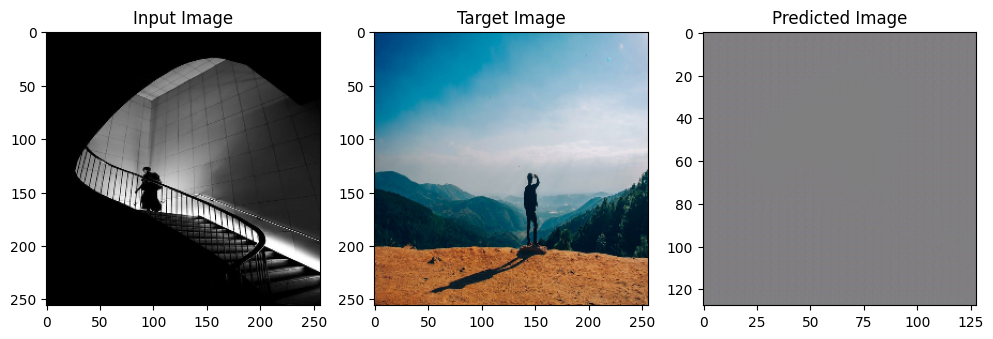

In [36]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the U-Net generator model
def build_generator():
    inputs = tf.keras.Input(shape=[256, 256, 3])


    e1 = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')(inputs)
    e1 = layers.ReLU()(e1)
    e2 = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same')(e1)
    e2 = layers.ReLU()(e2)

    b1 = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same')(e2)
    b1 = layers.ReLU()(b1)


    d1 = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(b1)
    d1 = layers.ReLU()(d1)
    d2 = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(d1)
    d2 = layers.ReLU()(d2)
    outputs = layers.Conv2D(3, (4, 4), padding='same')(d2)

    return tf.keras.Model(inputs, outputs)

# Define the PatchGAN discriminator model
def build_discriminator():
    inputs = tf.keras.Input(shape=[256, 256, 3])

    x = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    return tf.keras.Model(inputs, x)

# Define the loss functions
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output, generated_image, target_image):
    gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)
    l1_loss = tf.reduce_mean(tf.abs(target_image - generated_image))
    return gan_loss + 100 * l1_loss

# Create the models
generator = build_generator()
discriminator = build_discriminator()

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Load and preprocess images
def load_image(image_path, size=(256, 256)):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, size)
        image = (image / 127.5) - 1
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def load_dataset(input_path, target_path, size=(256, 256)):
    input_image = load_image(input_path, size)
    target_image = load_image(target_path, size)
    if input_image is not None and target_image is not None:
        return input_image, target_image
    else:
        raise FileNotFoundError("One or both of the image files could not be loaded.")

# Training
@tf.function
def train_step(input_image, target_image):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(input_image, training=True)
        real_output = discriminator(target_image, training=True)
        fake_output = discriminator(generated_image, training=True)

        gen_loss = generator_loss(fake_output, generated_image, target_image)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Example training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for input_image, target_image in dataset:
            train_step(input_image, target_image)
        print(f'Epoch {epoch} completed.')

# Visualize results
def generate_and_save_image(model, test_input, target):
    # Add batch dimension
    test_input = test_input[tf.newaxis, ...]
    target = target[tf.newaxis, ...]

    prediction = model(test_input, training=False)
    plt.figure(figsize=(12, 6))
    display_list = [test_input[0], target[0], prediction[0]]
    title = ['Input Image', 'Target Image', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)  # Denormalize
        plt.axis('on')
    plt.show()

# Define paths to test images
test_input_path = 'downloaded_image.jpg'
test_target_path = 'downloaded1_image.jpg'

# Check if files exist
def check_file_exists(file_path):
    if os.path.isfile(file_path):
        print(f"File exists: {file_path}")
        return True
    else:
        print(f"File does not exist: {file_path}")
        return False

# Ensure files exist before proceeding
if check_file_exists(test_input_path) and check_file_exists(test_target_path):
    try:
        test_input, test_target = load_dataset(test_input_path, test_target_path)
        generate_and_save_image(generator, test_input, test_target)
    except FileNotFoundError as e:
        print(e)
else:
    print("Please check the file paths and ensure the images are available.")


generator.save('generator_model.keras')
discriminator.save('discriminator_model.keras')
